In [1]:
import yaml
import os
import subprocess
import random
import numpy as np
import sys
import pandas as pd

from matplotlib import pyplot as plt
from tqdm import tqdm
from glob import glob
from traceback import print_exc
from multiprocessing import Pool

from vina import Vina
from meeko import MoleculePreparation, PDBQTMolecule
from rdkit import Chem
from rdkit.Chem.rdShapeHelpers import ComputeConfBox, ComputeUnionBox

In [2]:
with open("cfg.yaml", "r") as f:
    cfg = yaml.safe_load(f)

In [3]:
docked_file = glob(cfg["docked_folder"] + "/val_screens/")

KeyboardInterrupt: 

In [39]:
first_rmsds = []
top_rmsds = []
for docked_file in tqdm(docked_files):
    lig_file = "_".join(docked_file.split("_")[:3]) + ".pdbqt"
    lig = Chem.RemoveHs(PDBQTMolecule.from_file(lig_file).export_rdkit_mol())
    docked = PDBQTMolecule.from_file(docked_file)
    top = None
    first = None
    for docked_pdbqt in docked:
        docked_lig = Chem.RemoveHs(docked_pdbqt.export_rdkit_mol())
        rmsd = Chem.rdMolAlign.CalcRMS(docked_lig, lig, maxMatches=10000)
        top = rmsd if top is None or rmsd < top else top
        first = rmsd if first is None else first
    first_rmsds.append(first)
    top_rmsds.append(top)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 57.07it/s]


In [40]:
top_rmsds = np.array(top_rmsds)
first_rmsds = np.array(first_rmsds)
print("top 16 acc: ", sum(top_rmsds < 2)/len(top_rmsds))
print("top 1 acc: ", sum(first_rmsds < 2)/len(first_rmsds))

top 16 acc:  0.04819277108433735
top 1 acc:  0.03614457831325301


In [31]:
top_rmsds

array([1.82234643, 3.96701879, 0.93034103, 0.74810582])

In [32]:
docked_files[1]

'/home/boris/Data/BigBindDocked/Q9ZGI2/2hfk_e4h_lig_2hfk_A_rec_redocked.pdbqt'

(array([ 5., 12.,  8., 14., 20., 12.,  6.,  2.,  1.,  3.]),
 array([ 1.22242761,  2.21794896,  3.21347032,  4.20899167,  5.20451302,
         6.20003437,  7.19555572,  8.19107707,  9.18659842, 10.18211977,
        11.17764112]),
 <BarContainer object of 10 artists>)

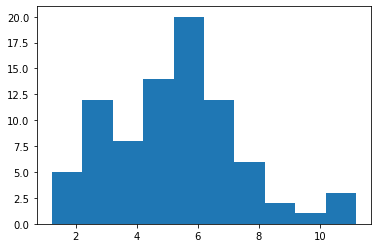

In [21]:
plt.hist(top_rmsds)

In [10]:
act_file = cfg["bigbind_folder"] + "/activities.csv"
all_activities = pd.read_csv(act_file)
activities = all_activities.query("rdkit_loadable == True and rdkit_embeddable == True").reset_index(drop=True)
activities = activities[~activities["canonical_smiles"].str.contains("\.")].reset_index(drop=True)

In [11]:
len(activities)*8/(60*24*7*1000)

0.9717365079365079